Theodoros Kassa Aragie

251163893

ECE 9309

Prof. Soodeh Nikan

February 17, 2025

# Implementing Agglomerative Clustering for a Recommender System

Database: https://www.kaggle.com/datasets/nechbamohammed/research-papers-dataset

In [1]:
# Misc Imports
import os
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from helper import *

# SciKit-Learn Imports
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering 
import scipy.cluster.hierarchy as shc 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer

# Tensorflow/Keras Imports
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
import tensorflow as tf
import tensorflow_hub as hub
import keras

# Restrict TensorFlow to only use the /GPU:0
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

# Set default Tensor type to double (float64)
keras.backend.set_floatx('float64')

# Ensure dump and parquets folders are ready
if not os.path.isdir("./dump"):
    os.makedirs("./dump")

# Prepare the Universal Sentence Encoder (USE)
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

2025-03-24 17:07:53.159817: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 17:07:53.169812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742850473.194369  105516 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742850473.203828  105516 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742850473.224293  105516 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

1 Physical GPUs, 1 Logical GPU


I0000 00:00:1742850477.627029  105516 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1742850477.628199  105516 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6167 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


## Load Preprocessed Data

In [2]:
# Load cleaned DF
cleanedDF:pd.DataFrame = pd.read_csv(
    "database_clean.csv"
)

# Load USE embeddings from cleaned dataset
embeddingsDF:pd.DataFrame = pd.read_csv(
    "use_embeddings.csv"
).drop(columns=["id"])

# Train 90%, Test 10%
# Calculate the training portion and the remainder
trnDF, tstDF = train_test_split(
    # No need to split into X and Y
    embeddingsDF, test_size=0.1, random_state=42
)
print(f"Trn: {trnDF.shape}, Tst: {tstDF.shape}")

# Compress via PCA to 2 features for AC plot:
pca:PCA = PCA(n_components=2).fit(trnDF)
trnComp:pd.DataFrame = pd.DataFrame(
    pca.transform(trnDF), columns=["P1", "P2"]
)
tstComp:pd.DataFrame = pd.DataFrame(
    pca.transform(tstDF), columns=["P1", "P2"]
)

Trn: (9958, 512), Tst: (1107, 512)


## Visualize Data and Tune for Best Agglomerative Clustering Model

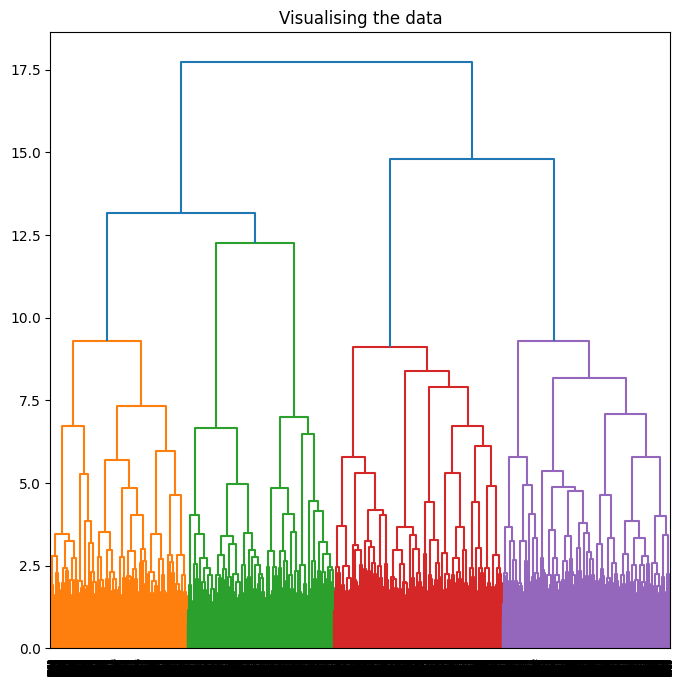

In [3]:
# Dendrogram
plt.figure(figsize =(8, 8)) 
plt.title('Visualising the data') 
Dendrogram = shc.dendrogram((shc.linkage(trnDF, method ='ward')))

In [4]:
# Custom wrapper for AgglomerativeClustering
# (to work with GridSearchCV)
class AgglomerativeClusteringCV(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters:int=2):
        # Set hyperparameters depending on inputted fields
        self.n_clusters = n_clusters
        self.model = None
    def fit(self, X, y=None):
        # AC model with current selection of hyperparameters
        self.model = AgglomerativeClustering(
            n_clusters=self.n_clusters,
        )
        # Fit and store cluster labels
        self.labels_ = self.model.fit_predict(X)
        return self
    def fit_predict(self, X, y=None):
        return self.fit(X).labels_

# Custom Silhouette Scorer
def silhScorer(estimator:AgglomerativeClusteringCV, X:npt.NDArray):
    # Get cluster labels
    labels:npt.NDArray = estimator.fit_predict(X)
    # Need at least 2 clusters)
    if len(set(labels)) < 2:
        return -1
    return silhouette_score(X, labels)

# Define Hyperparameter Grid
paramGrid:dict[str, list] = {
    # Number of clusters to search
    'n_clusters': [2, 3, 4, 5, 6, 7],
}

# Check if search was already saved, otherwise run it
gridSearch:GridSearchCV
if not os.path.isfile("./dump/gridSearch.pkl"):
    gridSearch = GridSearchCV(
        estimator=AgglomerativeClusteringCV(),
        param_grid=paramGrid,
        scoring=silhScorer, # Use custom Silhouette Score function
        cv=3, # 3-fold cross-validation
        n_jobs=-1 # Use max CPU cores possible
    )
    # Fit GridSearch
    gridSearch.fit(trnDF)
    # Save it for later
    joblib.dump(gridSearch, "./dump/gridSearch.pkl")
else:
    gridSearch = joblib.load("./dump/gridSearch.pkl")

# Best Parameters & Score
print("Best Parameters:", gridSearch.best_params_)
print("Best Silhouette Score:", gridSearch.best_score_)

Best Parameters: {'n_clusters': 2}
Best Silhouette Score: 0.01900548233886569


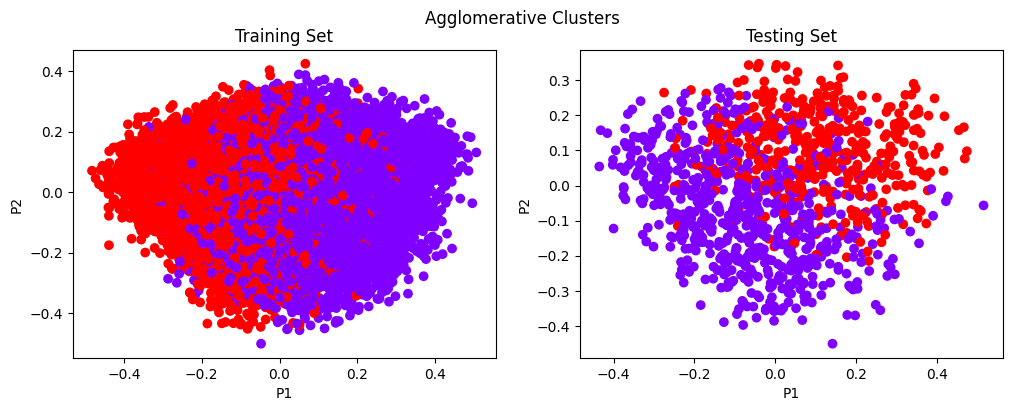

In [5]:
# Instantiate optimal AC model
bestAC:AgglomerativeClustering = AgglomerativeClustering(
    **gridSearch.best_params_
)
# Calculate labels
trnLabels = bestAC.fit_predict(trnDF)
trnDF["cluster"] = trnLabels
tstLabels = bestAC.fit_predict(tstDF)
tstDF["cluster"] = tstLabels

# Plotting optimial AC clusters
plt.figure(figsize=(12, 4))
plt.suptitle("Agglomerative Clusters")
plt.subplot(1, 2, 1)
plt.scatter(
    trnComp["P1"], trnComp["P2"], 
    c=trnLabels,
    cmap="rainbow"
)
plt.xlabel("P1")
plt.ylabel("P2")
plt.title("Training Set")
plt.subplot(1, 2, 2)
plt.scatter(
    tstComp["P1"], tstComp["P2"], 
    c=tstLabels,
    cmap="rainbow"
)
plt.xlabel("P1")
plt.ylabel("P2")
plt.title("Testing Set")
plt.show()

## Make Recomendations, Plot Cosine Similarity, Save Model

Top 10 papers for paper 0:
                                                abstract  \
294    We consider a variant of bin packing called mu...   
515    Within a production theoretic framework, this ...   
1681   In this paper, a shadow detection and removal ...   
3639   Summary#R##N#Computing the extremal eigenvalue...   
4380   We import a duality notion coming from polymat...   
5934   Given a graph G = (V, E), a node is called per...   
6528   In this paper we derive a new controllability ...   
7597   There is no known general formula to calculate...   
7792   This paper extends the problem of palindrome s...   
10121  Given a mutual exclusion algorithm MXd for \({...   

                                                 authors  n_citation  \
294                  ['Boaz Patt-Shamir', 'Dror Rawitz']          50   
515                 ['Jens Leth Hougaard', 'Mich Tvede']          50   
1681   ['Dale Joshua R. Del Carmen', 'Rhandley Doming...           0   
3639                    

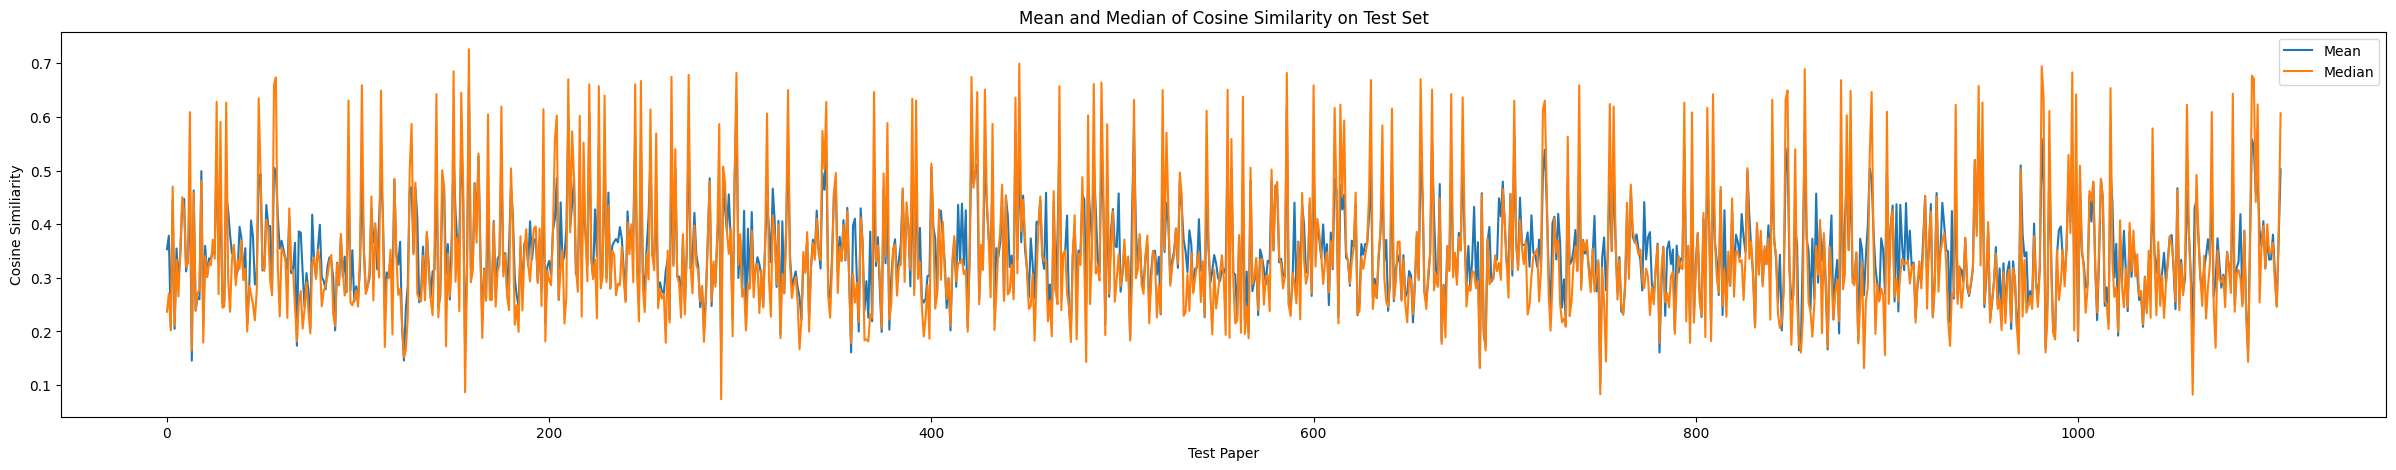

In [6]:
# Function to recommend top n papers (default to top_n=10)
def recommendPapers(top_n:int=10):
    # Define lists
    corrMeanList:list[float] = []
    corrMedList:list[float] = []
    simsList:list[npt.NDArray] = []
    cosMeanList:list[float] = []
    cosMedList:list[float] = []
    topList:list[list[int]] = []
    tfidfList:list[npt.NDArray] = []
    testVecList:list[npt.NDArray] = []
    topVecList:list[npt.NDArray] = []
    # For each paper in the test set
    # (so tstDF shape from before adding the cluster column):
    for testPaperIndex in range(tstDF.shape[0]):
        testPaperClusters:pd.DataFrame = tstDF.iloc[
            testPaperIndex
        ]["cluster"]
        # Get all training papers in the same cluster
        sameClusterPapers:pd.DataFrame = trnDF[
            trnDF["cluster"] == testPaperClusters
        ]
        # Ensure index alignment before selecting embeddings
        sameClusterIndices:pd.Index = sameClusterPapers.index.intersection(
            trnDF.index
        )
        # Get appropriate vectors
        testEmbeddings:npt.NDArray = tstDF.iloc[
            testPaperIndex
        ].values.reshape(1, -1)
        trainEmbeddings:npt.NDArray = trnDF.loc[
            sameClusterIndices
        ].values  # Exclude cluster column
        # Compute the distances between points
        distances:npt.NDArray = euclidean_distances(testEmbeddings, trainEmbeddings)[0]
        # Get top-N most similar papers, highest similarity first
        topIndices:npt.NDArray = np.argsort(distances)[-top_n:][::-1]
        topPapers:list[int] = sorted(sameClusterIndices[topIndices].to_list())
        topEmbeddings:npt.NDArray = trnDF.iloc[topIndices].values

        # Print top 10 recommendations for current paper:
        print(f"Top 10 papers for paper {testPaperIndex}:")
        print(cleanedDF.iloc[topPapers])

        # Compute cosine similarity
        similarities:npt.NDArray = cosine_similarity(
            testEmbeddings, topEmbeddings
        )
        # Pearson correlation
        corrMean, corrMedian = compute_pearson_correlation(
            testEmbeddings, topEmbeddings.reshape(1, top_n, -1)
        )
        # Cosine similarity score 
        cosMean, cosMedian = cosine_similarity_mean_median(similarities)
        # TF-IDF
        (
            tfidfTestMatrix, testVectors, topRecommendedVectors
        ) = compute_tfidf_similarity(
            test_texts=cleanedDF.loc[[0], "abstract"].tolist(),
            top10_texts=[cleanedDF.loc[idx, "abstract"] for idx in topPapers]
        )
        # Store values for each index
        corrMeanList.append(corrMean)
        corrMedList.append(corrMedian)
        simsList.append(similarities)
        cosMeanList.append(cosMean)
        cosMedList.append(cosMedian)
        topList.append(topPapers)
        tfidfList.append(tfidfTestMatrix)
        testVecList.append(testVectors)
        topVecList.append(topRecommendedVectors)
    # Plot average cosine similarities:
    plot_cosine_similarity(cosMeanList, cosMedList)
    # Return data
    return pd.DataFrame({
        "correlation_mean": corrMeanList,
        "correlation_median": corrMedList,
        "cosine_similarity": simsList,
        "cosine_mean": cosMeanList,
        "cosine_median": cosMedList,
        "top_paper_indices": topList,
        "tfidf_matrix": tfidfList,
        "test_vectors": testVecList,
        "top_vectors": topVecList
    })
# Example usage on a query string
recDF:pd.DataFrame= recommendPapers(top_n=10)
recDF[[
    "correlation_mean", "correlation_median", "cosine_mean",
    "cosine_median", "top_paper_indices"
]].to_csv("./dump/recs.csv")

In [7]:
# Save the trained model
joblib.dump(bestAC, "./dump/acModel.pkl")

['./dump/acModel.pkl']

## Test Loaded Model with a Query String

In [8]:
# Reload the model
loadedModel:AgglomerativeClustering = joblib.load("./dump/acModel.pkl")

Top 10 papers for query 'stochastic hybrid system modeling':
                                               abstract  \
441   Disasters have devastating effects on communit...   
1360  Doubt is key to becoming a good programmer. If...   
1862  In many shopping sites such as Amazon.com it i...   
2037  Focused attention meditations have been shown ...   
5307  This project has received funding from the Eur...   
6718  In this study, we propose a broadcasting and c...   
6850  Children are a fast growing user group on the ...   
7494  Abstract  Introduction  Access to reliable and...   
8435  Music streaming platforms enable people to acc...   
8766  Health consumers are increasingly using the In...   

                                                authors  n_citation  \
441   ['Kimberly Glasgow', 'Clay Fink', 'Jessica Vit...           0   
1360                             ['Gerard J. Holzmann']           0   
1862  ['Kyosuke Maeda', 'Yoshinori Hijikata', 'Satos...           0   
2037 

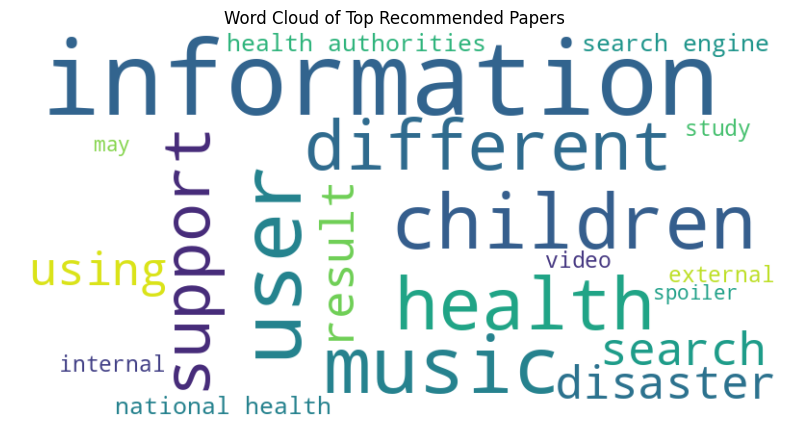

In [9]:
# Function to recommend top n papers (default to top_n=10)
def selectPapers(query:str, top_n:int=10):
    # Embed query string using Universal Serial Encoder
    queryEmbeddings:npt.NDArray = embed([query]).numpy()
    # Define lists
    corrMeanList:list[float] = []
    corrMedList:list[float] = []
    simsList:list[npt.NDArray] = []
    topList:list[list[int]] = []
    cosMeanList:list[float] = []
    cosMedList:list[float] = []
    tfidfList:list[npt.NDArray] = []
    testVecList:list[npt.NDArray] = []
    topVecList:list[npt.NDArray] = []
    # Get appropriate vectors (excluding the cluster column)
    trainEmbeddings:npt.NDArray = trnDF.drop(columns=["cluster"], axis=1).values # Exclude cluster column
    # Compute the distances between the query embedding and all training papers
    qDistances:npt.NDArray = euclidean_distances(queryEmbeddings, trainEmbeddings)[0]  # 1D array of distances to each training paper
    # Find the closest paper to the query
    closestPaperIndex:int = np.argmin(qDistances)  # Index of the closest paper
    closestCluster:int = trnDF.iloc[closestPaperIndex]["cluster"]  # Cluster label for the closest paper
    # Get all papers in the same cluster
    sameClusterPapers:pd.DataFrame = trnDF[trnDF["cluster"] == closestCluster]
    sameClusterIndices:pd.Index = sameClusterPapers.index.intersection(trnDF.index)
    # Get appropriate vectors (excluding the cluster column)
    trainEmbeddings:npt.NDArray = trnDF.loc[sameClusterIndices].drop(columns=["cluster"]).values
    # Compute the distances between the query embedding and the papers in the selected cluster
    distances:npt.NDArray = euclidean_distances(queryEmbeddings, trainEmbeddings)[0]
    # Get top-N most similar papers, highest similarity first
    topIndices:npt.NDArray = np.argsort(distances)[-top_n:][::-1]
    topPapers:list[int] = sorted(sameClusterIndices[topIndices].to_list())
    topEmbeddings:npt.NDArray = trnDF.drop(columns=["cluster"], axis=1).iloc[topIndices].values
    
    # Print top 10 recommendations for current paper:
    print(f"Top 10 papers for query '{query}':")
    print(cleanedDF.iloc[topPapers])
    
    # Compute cosine similarity
    similarities:npt.NDArray = cosine_similarity(
        queryEmbeddings, topEmbeddings
    )
    # Pearson correlation
    corrMean, corrMedian = compute_pearson_correlation(
        queryEmbeddings, topEmbeddings.reshape(1, top_n, -1)
    )
    # Cosine similarity score 
    cosMean, cosMedian = cosine_similarity_mean_median(similarities)
    # TF-IDF
    (
        tfidfQueryMatrix, queryVectors, topSelectedVectors
    ) = compute_tfidf_similarity(
        test_texts=cleanedDF.loc[[0], "abstract"].tolist(),
        top10_texts=[cleanedDF.loc[idx, "abstract"] for idx in topPapers]
    )
    # Generate wordCloud object
    currWCObj:WordCloud = createWCloud(
        paper_ids=cleanedDF.iloc[topPapers]["id"].to_list(),
        papers=cleanedDF
    )
    # Store values for each index
    corrMeanList.append(corrMean)
    corrMedList.append(corrMedian)
    simsList.append(similarities)
    cosMeanList.append(cosMean)
    cosMedList.append(cosMedian)
    topList.append(topPapers)
    tfidfList.append(tfidfQueryMatrix)
    testVecList.append(queryVectors)
    topVecList.append(topSelectedVectors)
    # Return data
    return pd.DataFrame({
        "correlation_mean": corrMeanList,
        "correlation_median": corrMedList,
        "cosine_similarity": simsList,
        "cosine_mean": cosMeanList,
        "cosine_median": cosMedList,
        "top_paper_indices": topList,
        "tfidf_matrix": tfidfList,
        "test_vectors": testVecList,
        "top_vectors": topVecList
    })

# Test on new papers
queryDF:pd.DataFrame = selectPapers(query="stochastic hybrid system modeling", top_n=10)
queryDF[[
    "correlation_mean", "correlation_median", "cosine_mean",
    "cosine_median", "top_paper_indices"
]].to_csv("./dump/query.csv")

## TF-IDF and Feature Importance Plot

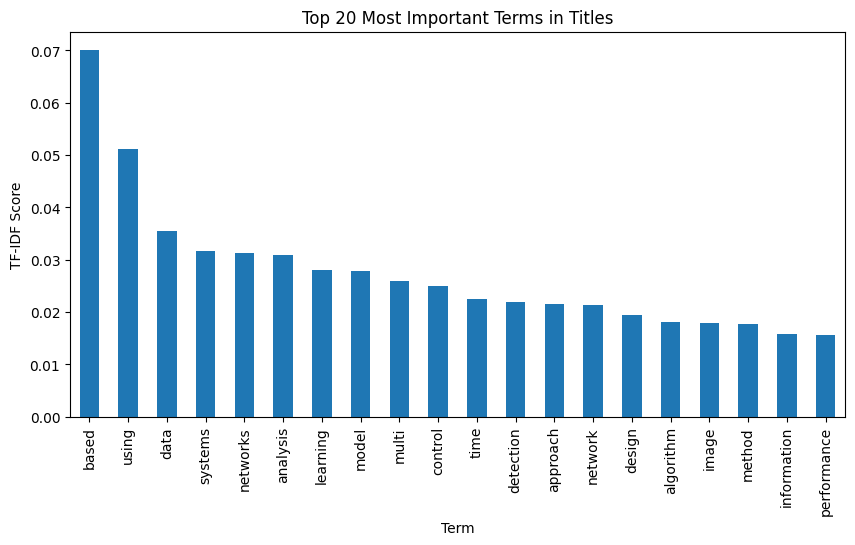

In [10]:
# Convert titles into TF-IDF representation
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = vectorizer.fit_transform(cleanedDF["title"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out()
)

# Plot top 20 TF-IDF terms
tfidf_df.mean().nlargest(20).plot(kind='bar', figsize=(10, 5))
plt.title("Top 20 Most Important Terms in Titles")
plt.xlabel("Term")
plt.ylabel("TF-IDF Score")
plt.show()